In [527]:
import pandas as pd
import numpy as np
import torch
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from ast import literal_eval
import matplotlib.pyplot as plt
from textstat.textstat import textstat
from gensim.corpora import wikicorpus
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import nltk
from collections import defaultdict
%matplotlib inline
# Make it pretty
plt.style.use('ggplot')

In [528]:
file = '../data/enwiki.observations.text_wp10.30k.tsv'
raw_data = pd.read_csv(file, sep='\t', header=None)
data = pd.DataFrame(data=list(raw_data[0].apply(literal_eval)))

In [529]:
data = data[data['text'] != ""]
data = data[data['text'].str.contains("#redirect") == False]
data = data[data['text'].str.contains("may refer to:\n\n*") == False]
data = data[data['text'].str.contains("can refer to:\n") == False]
data = data[data['text'].str.contains("could refer to:\n") == False]
data = data[data['text'].str.contains("#REDIRECT") == False]
data = data[data['text'].str.contains("== Matches ==\n:") == False]
data = data[data['text'].str.contains("{{underconstruction") == False]

In [530]:
classes = {"stub": 0, "start": 1, "c": 2, "b": 3, "ga": 4, "fa": 5} 
data["label"] = data['label'].map(classes)

In [472]:
def truncated_5000_char_article(raw_article):
    return(raw_article[:10000])
#data['text'] = data['text'].apply(truncated_5000_char_article)

In [531]:
data = data[:15000].copy()

## Declare characters of interest and # of letters

In [532]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

import unicodedata
import string

all_chars = string.ascii_letters + string.punctuation + ' '
n_chars = len(all_chars)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def create_labeled_docs_dict(database, empty_default_dict):
    database = dict(database.T)
    for i in database.items():
        label = i[1][0]
        text = i[1][3]
        empty_default_dict[label].append(text)
    return empty_default_dict

# Build the category_lines dictionary, a list of names per language
all_labels = [0,1,2,3,4,5]
label_docs = defaultdict(list)
label_docs = create_labeled_docs_dict(data, label_docs)

## Turning characters into vectors
To represent a single letter, we use a “one-hot vector” of size ```<1 x n_letters>```. A one-hot vector is filled with 0s except for a 1 at index of the current letter. To make a word we join a bunch of those into a 2D matrix ```<line_length x 1 x n_letters>```.

In [533]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def find_char_index(char):
    return all_chars.find(char)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def char_to_tensor(char):
    tensor = torch.zeros(1, n_chars)
    tensor[0][find_char_index(char)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def doc_to_tensor(word):
    tensor = torch.zeros(len(word), 1, n_chars)
    for idx, char in enumerate(word):
        tensor[idx][0][find_char_index(char)] = 1
    return tensor

# Building RNN

In [534]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
n_labels = 6

rnn = RNN(n_chars, n_hidden, n_labels)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

For the sake of efficiency we don’t want to be creating a new Tensor for every step, so we will use ```doc_to_tensor``` instead of ```char_to_tensor``` and use slices. This could be further optimized by pre-computing batches of Tensors.

In [535]:
input = doc_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-1.7854, -1.8454, -1.7734, -1.7237, -1.7844, -1.8435]],
       grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ```<1 x n_categories>``` Tensor, where every item is the likelihood of that category (higher is more likely).

# Training our RNN
Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use ```Tensor.topk``` to get the index of the greatest value:

In [536]:
def label_from_output(output):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return all_labels[label_i], label_i

print(label_from_output(output))

(3, 3)


We will also want a quick way to get a training example (a doc and its label):

In [537]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    label = randomChoice(all_labels)
    doc = randomChoice(label_docs[label])
    label_tensor = torch.tensor([all_labels.index(label)], dtype=torch.long)
    doc_tensor = doc_to_tensor(doc)
    return label, doc, label_tensor, doc_tensor

#for i in range(10):
#    label, doc, label_tensor, doc_tensor = randomTrainingExample()
#    print('category =', label, '/ doc =', doc)

Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it’s wrong.

For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.

In [538]:
criterion = nn.NLLLoss()

Each loop of training will:
- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and
- Keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [539]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(label_tensor, doc_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(doc_tensor.size()[0]):
        output, hidden = rnn(doc_tensor[i], hidden)

    loss = criterion(output, label_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the ```train``` function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every ```print_every``` examples, and take an average of the loss.

In [540]:
import time
import math

n_iters = 2000
print_every = 10
plot_every = 10



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    label, doc, label_tensor, doc_tensor = randomTrainingExample()
    output, loss = train(label_tensor, doc_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = label_from_output(output)
        correct = '✓' if guess == label else '✗ (%s)' % label
        #print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, 'predicted -->', find_regressed_output(output), correct))
        print(f"{iter},{timeSince(start)}, {round(loss,4)}, predicted: {find_regressed_output(output)}, label: {int(output.topk(1,1, True)[1])} {correct}")

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

10,0m 26s, 1.7068, predicted: 3.62, label: 4 ✓
20,0m 48s, 1.7034, predicted: 3.74, label: 4 ✓
30,1m 26s, 1.8437, predicted: 3.84, label: 4 ✗ (5)
40,1m 57s, 1.8002, predicted: 3.92, label: 4 ✗ (2)
50,2m 32s, 1.8072, predicted: 4.03, label: 4 ✗ (2)
60,2m 59s, 1.7475, predicted: 4.24, label: 4 ✗ (0)
70,3m 26s, 1.8185, predicted: 4.11, label: 4 ✗ (0)
80,3m 44s, 1.8246, predicted: 4.23, label: 4 ✗ (3)
90,4m 8s, 1.7936, predicted: 4.19, label: 4 ✗ (5)
100,4m 27s, 1.8421, predicted: 4.27, label: 4 ✗ (3)
110,4m 44s, 1.8202, predicted: 4.2, label: 4 ✗ (0)
120,5m 5s, 1.8062, predicted: 4.19, label: 4 ✗ (1)
130,5m 29s, 1.7211, predicted: 0, label: 0 ✓
140,5m 49s, 1.8572, predicted: 3.26, label: 4 ✗ (0)
150,6m 5s, 1.7927, predicted: 1.33, label: 1 ✗ (2)
160,6m 32s, 1.7844, predicted: 1.45, label: 1 ✗ (4)
170,7m 7s, 1.7491, predicted: 1.78, label: 1 ✗ (2)
180,7m 40s, 1.7446, predicted: 2.67, label: 2 ✓
190,8m 12s, 1.7448, predicted: 1.35, label: 2 ✗ (1)
200,8m 32s, 1.8072, predicted: 0, label: 0 ✗ 

1610,82m 38s, 1.7311, predicted: 5, label: 5 ✗ (4)
1620,83m 5s, 1.7067, predicted: 5, label: 5 ✗ (1)
1630,83m 37s, 1.6721, predicted: 5, label: 5 ✓
1640,83m 50s, 1.725, predicted: 5, label: 5 ✗ (4)
1650,84m 4s, 1.7675, predicted: 1.37, label: 1 ✗ (3)
1660,84m 23s, 1.7338, predicted: 4.4, label: 4 ✗ (3)
1670,84m 51s, 1.7212, predicted: 5, label: 5 ✗ (4)
1680,85m 5s, 1.7448, predicted: 1.38, label: 1 ✗ (5)
1690,85m 28s, 1.7384, predicted: 5, label: 5 ✗ (4)
1700,85m 47s, 1.8385, predicted: 5, label: 5 ✗ (2)
1710,86m 20s, 1.7531, predicted: 5, label: 5 ✗ (3)
1720,86m 45s, 1.7572, predicted: 5, label: 5 ✗ (3)
1730,87m 16s, 1.9963, predicted: 0, label: 0 ✗ (1)
1740,87m 39s, 1.8317, predicted: 5, label: 5 ✗ (2)
1750,88m 15s, 1.7651, predicted: 5, label: 5 ✗ (3)
1760,88m 38s, 1.7044, predicted: 5, label: 5 ✗ (4)
1770,89m 10s, 1.6947, predicted: 5, label: 5 ✗ (4)
1780,89m 47s, 1.6388, predicted: 5, label: 5 ✓
1790,90m 55s, 1.8306, predicted: 5, label: 5 ✗ (1)
1800,91m 26s, 1.8114, predicted: 5,

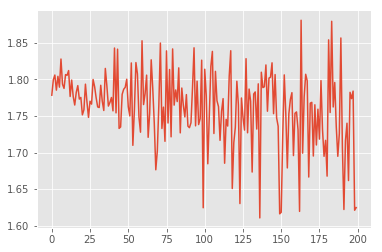

In [541]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [ ]:
import pickle
# Save to file in the current working directory
pkl_filename = "RNN_aug22.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(rf, file)
print(mean_squared_error(y_test, predictions))

In [409]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_labels, n_labels)
n_confusion = 100

# Just return an output given a line
def evaluate(doc_tensor):
    hidden = rnn.initHidden()

    for i in range(doc_tensor.size()[0]):
        output, hidden = rnn(doc_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    label, doc, label_tensor, doc_tensor = randomTrainingExample()
    output = evaluate(doc_tensor)
    guess, guess_i = label_from_output(output)
    label_i = all_labels.index(label)
    confusion[label_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_labels):
    confusion[i] = confusion[i] / confusion[i].sum()

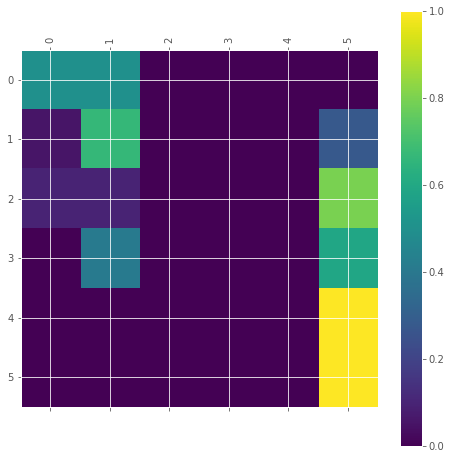

In [410]:
# Set up plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_labels, rotation=90)
ax.set_yticklabels([''] + all_labels)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [411]:
def predict(input_doc, n_predictions=1):
    print('\n> %s' % 'doc predicted')
    with torch.no_grad():
        output = evaluate(doc_to_tensor(input_doc))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            label_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_labels[label_index]))
            predictions.append([value, all_labels[label_index]])


In [412]:
predict('asd')


> doc predicted
(-1.45) 5


In [413]:
import lxml.etree
import urllib
import urllib.request
import pandas as pd


def get_wiki_xml(title):
    title = title
    params = { "format":"xml", "action":"query", "prop":"revisions", "rvprop":"timestamp|user|comment|content" }
    params["titles"] = "API|%s" % urllib.parse.quote(title.encode("utf8"))
    qs = "&".join("%s=%s" % (k, v)  for k, v in params.items())
    url = "http://en.wikipedia.org/w/api.php?%s" % qs
    tree = lxml.etree.parse(urllib.request.urlopen(url))
    revs = tree.xpath('//rev')
    return (revs[-1].text)

In [414]:
tex = get_wiki_xml('George W. Woodruff School of Mechanical Engineering')

In [415]:
predict(tex)


> doc predicted
(-0.76) 0


In [421]:
max(output[0])

tensor(-1.3780, grad_fn=<SelectBackward>)

In [423]:
n_predictions = 1
print('\n> %s' % 'doc predicted')
with torch.no_grad():
    output = evaluate(doc_to_tensor(tex))
    print(output)

# Get top N categories
topv, topi = output.topk(n_predictions, 1, True)
predictions = []

for i in range(n_predictions):
    value = topv[0][i].item()
    label_index = topi[0][i].item()
    print('(%.2f) %s' % (value, all_labels[label_index]))
    predictions.append([value, all_labels[label_index]])



> doc predicted
tensor([[-0.7589, -2.1116, -2.1895, -2.3534, -2.3259, -2.2439]])
(-0.76) 0


In [371]:
output

tensor([[-0.8758, -0.8659, -2.6876, -2.9720, -3.8596, -3.7955]])

In [42]:
#def doc2int_vec(raw_article):
    markup_2_space = str.maketrans(":|!,.=", ' '*6)
    article = (raw_article.translate(markup_2_space)).split()
    dict_of_words = dict([(y,x+1) for x,y in enumerate(sorted(set(article)))])
    return [dict_of_words[x] for x in article]

data1000['doc2int'] = data1000['text'].apply(doc2int_vec)
y = data1000.label.values

## Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(data1000.doc2int.values, y, test_size=0.20, random_state=910)

## Bi-Directional RNN

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

max_features = 20000
maxlen = 12000
batch_size = 32

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()
model.add(Embedding(max_features, 64, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.75))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=[X_test, y_test])

/Users/austin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/austin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


KeyboardInterrupt: 

In [348]:
def find_regressed_output(output):
    _, top_i = output.topk(1)
    if int(top_i[0]) in [1, 2, 3, 4]:
        x = int(top_i)
        dif_n_lower = round((float(output[0][x]) - float(output[0][x-1]))*10,2)
        dif_n_higher = round((float(output[0][x]) - float(output[0][x+1]))*10,2)
        predicted_label = round((x-1) + (2/(dif_n_lower + dif_n_higher)) * dif_n_lower,2)
        return predicted_label
    else:
        return int(top_i[0])

In [434]:
find_regressed_output(output)

0

In [445]:
label, doc, label_tensor, doc_tensor = randomTrainingExample()
output, loss = train(label_tensor, doc_tensor)

In [456]:
find_regressed_output(output)

4.68

In [447]:
evaluate(doc_tensor)

tensor([[-1.7401, -1.8783, -1.7822, -1.8116, -1.7463, -1.7984]],
       grad_fn=<LogSoftmaxBackward>)